In [82]:
import pandas as pd

In [83]:
df = pd.read_csv("../data/fromAPI/combined_data.csv")

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_7141/2490449324.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/fromAPI/combined_data.csv")


In [84]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["departure_plan_hour"] = df["departure_plan"].dt.hour


In [85]:
df.dropna(subset=["departure_plan"], inplace=True)

In [86]:
# Set index to datetime
df.set_index('departure_plan', inplace=True)



In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1491243 entries, 2024-06-24 00:01:00 to 2024-06-28 23:54:00
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   line                   1491243 non-null  object        
 1   path                   1338011 non-null  object        
 2   category               1491243 non-null  int64         
 3   name                   1491243 non-null  object        
 4   state                  1491243 non-null  object        
 5   city                   1491243 non-null  object        
 6   long                   1491243 non-null  float64       
 7   lat                    1491243 non-null  float64       
 8   arrival_plan           1338011 non-null  datetime64[ns]
 9   arrival_change         1157377 non-null  datetime64[ns]
 10  departure_change       1260100 non-null  datetime64[ns]
 11  arrival_delay_m        1491243 non-null  int64         


In [88]:
# Select only numeric columns for resampling
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Resample to hourly data and calculate the mean
hourly_data = numeric_cols.resample('h').mean()

In [89]:
hourly_data.iloc[16,4] = hourly_data[hourly_data["departure_plan_hour"] == 15].arrival_delay_m.median()
hourly_data.iloc[17,4] = hourly_data[hourly_data["departure_plan_hour"] == 16].arrival_delay_m.median()
hourly_data.iloc[18,4] = hourly_data[hourly_data["departure_plan_hour"] == 17].arrival_delay_m.median()

In [90]:
tsa = hourly_data[["departure_delay_m"]]

In [91]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tsa["departure_delay_m"] = scaler.fit_transform(hourly_data[["departure_delay_m"]])

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_7141/2695928400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsa["departure_delay_m"] = scaler.fit_transform(hourly_data[["departure_delay_m"]])


In [92]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [93]:
result = adfuller(tsa['departure_delay_m'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] < 0.05:
    print("Series is stationary. No differencing needed.")

ADF Statistic: -5.233648077548473
p-value: 7.502850728335639e-06
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}
Series is stationary. No differencing needed.


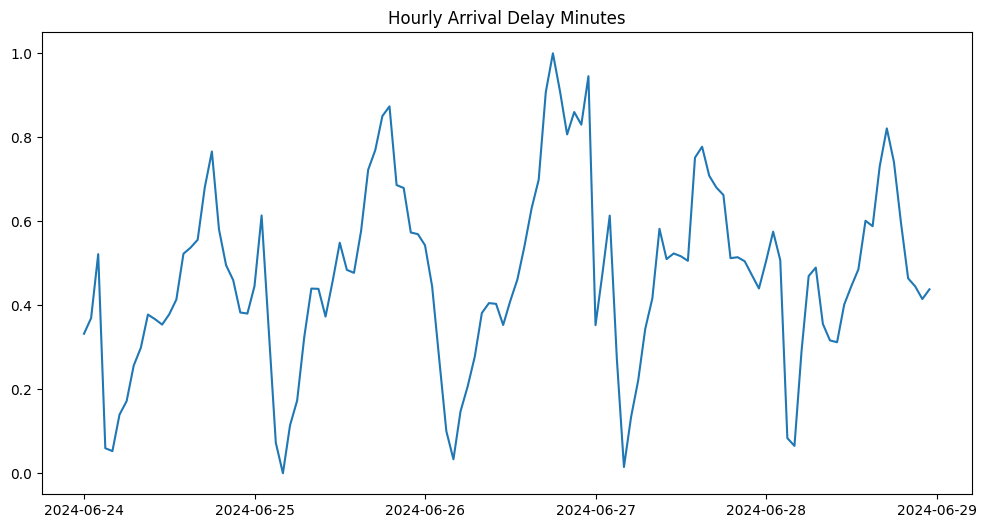

In [94]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'])
plt.title('Hourly Arrival Delay Minutes')
plt.show()

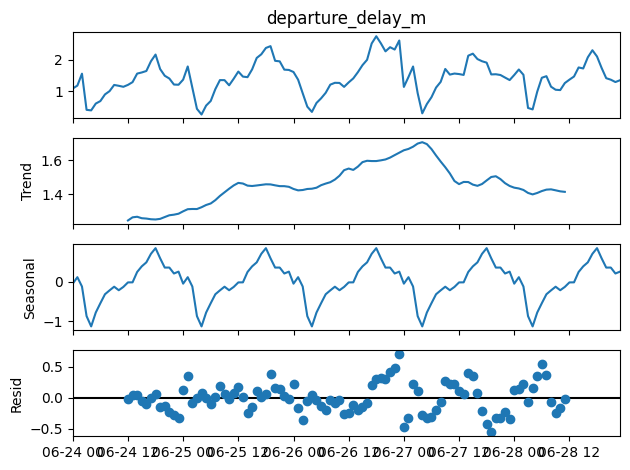

In [95]:
decomposition = seasonal_decompose(hourly_data['departure_delay_m'], model='additive')
decomposition.plot()
plt.show()

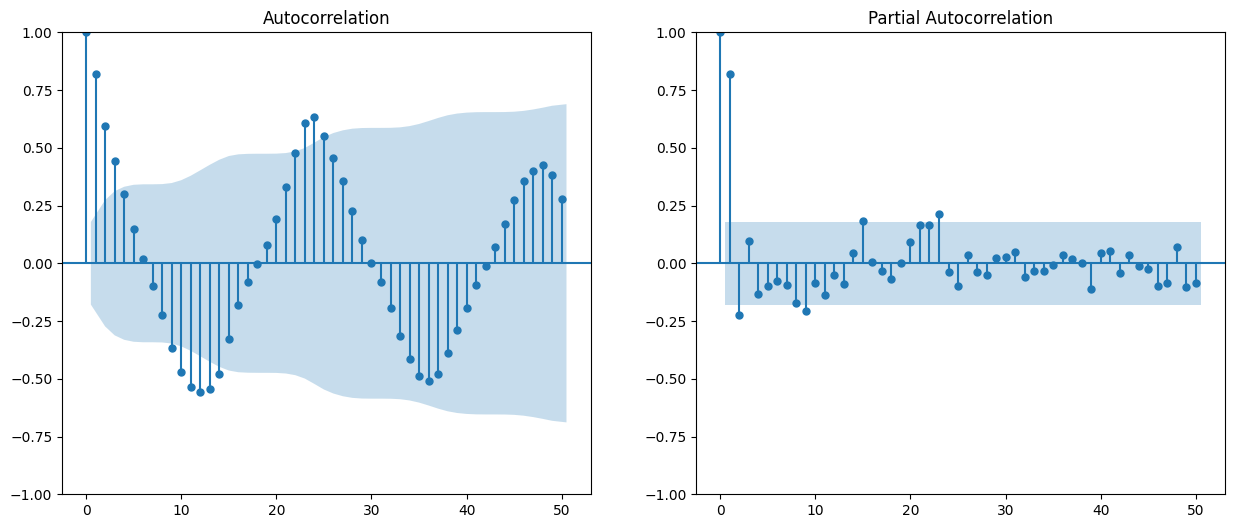

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(tsa['departure_delay_m'], lags=50, ax=axes[0])
plot_pacf(tsa['departure_delay_m'], lags=50, ax=axes[1])
plt.show()

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
model = SARIMAX(tsa['departure_delay_m'], 
                order=(1, 0, 1), #CHANGE
                seasonal_order=(1, 0, 1, 24))#CHANGE
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  departure_delay_m   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                  91.267
Date:                            Tue, 09 Jul 2024   AIC                           -172.534
Time:                                    09:39:25   BIC                           -158.596
Sample:                                06-24-2024   HQIC                          -166.874
                                     - 06-28-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.048     18.666      0.000       0.809       0.999
ma.L1          0.0048      0.128   

/Users/nokkyu/Documents/greenbootcamps/FinalProject/SavingDB/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


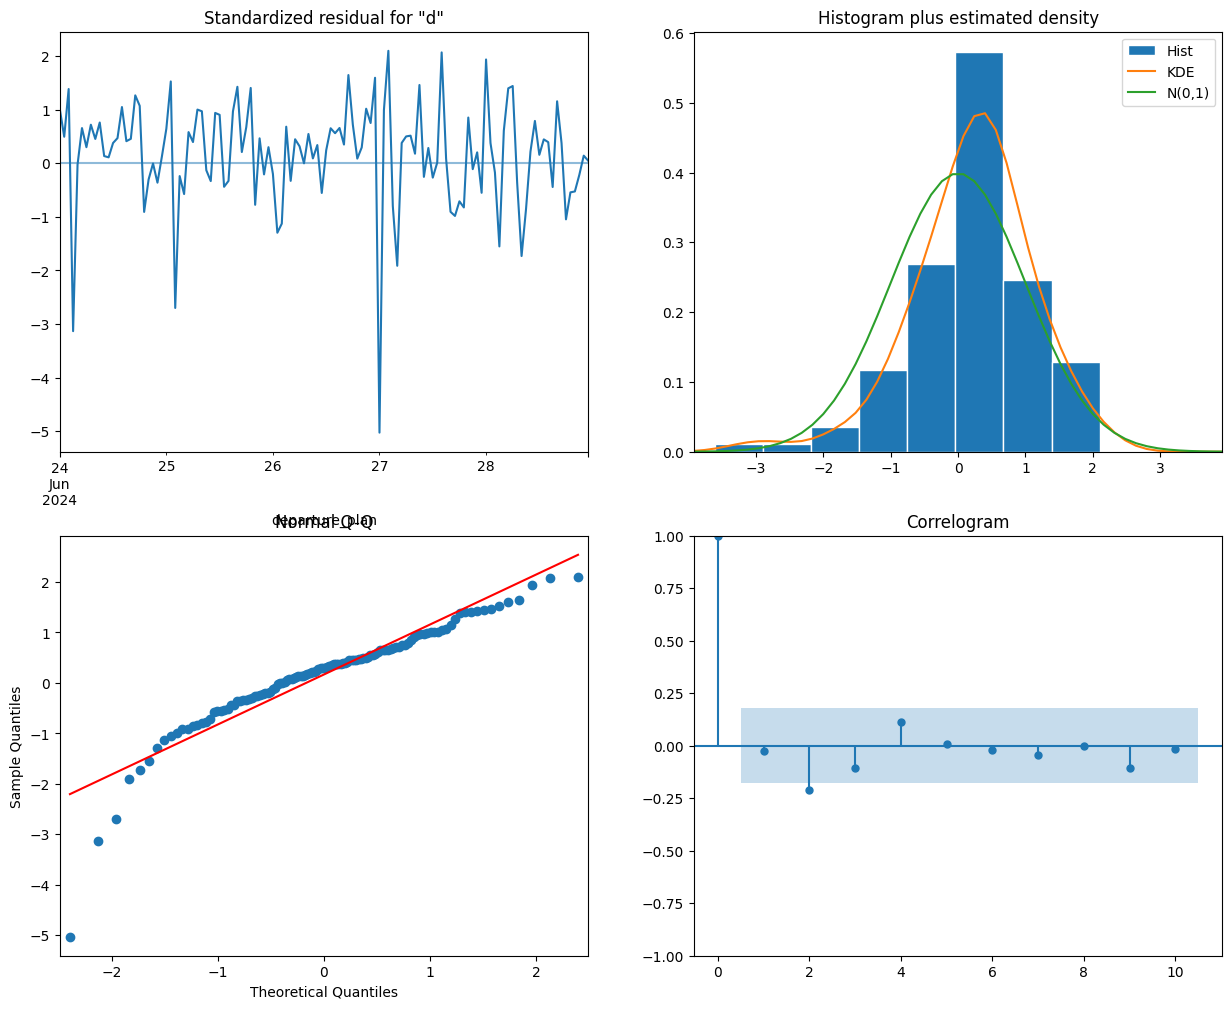

In [98]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/var/folders/xc/x124yzd57d906mgtpgc25wkh0000gn/T/ipykernel_7141/1112341068.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]


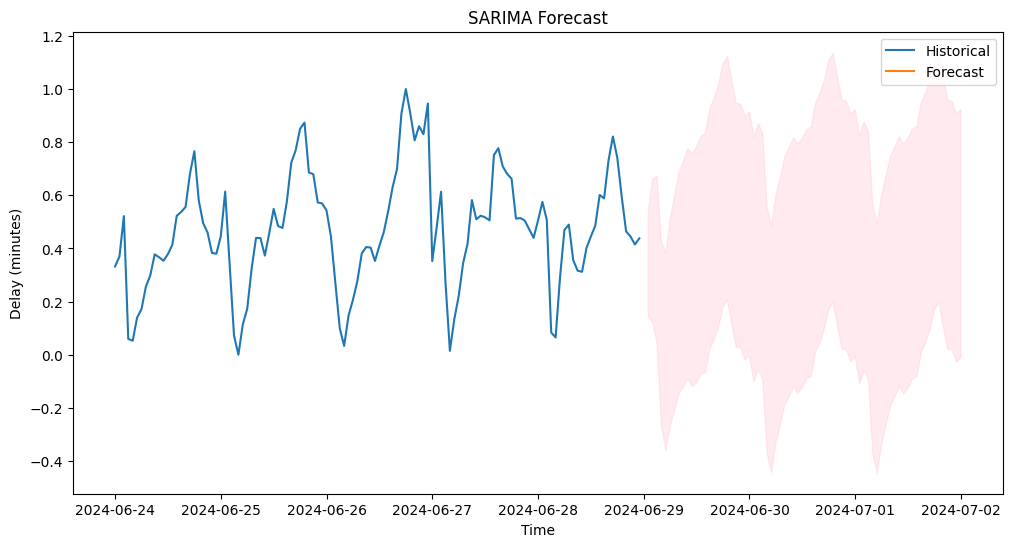

In [99]:
forecast_steps = 72
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(tsa['departure_delay_m'], label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Delay (minutes)')
plt.legend()
plt.show()

outlier detection
combine the two datasets to one to predict a week
show accuraacy with second dataset

test bundesländer if they follow the pattern

# outlier detection

In [100]:
predicted_normalized = model_fit.predict(start=tsa.index[0], end=tsa.index[-1])
#predicted_values = scaler.inverse_transform(predicted_normalized.to_frame())
#denormalized_values = scaler.inverse_transform(tsa)
#tsa["departure_delay_m"] = denormalized_values


In [101]:
pred = tsa.copy()
pred["departure_delay_m"] = predicted_normalized

In [102]:
tsa

,departure_delay_m
departure_plan,
2024-06-24 00:00:00,0.332229
2024-06-24 01:00:00,0.369475
2024-06-24 02:00:00,0.521795
2024-06-24 03:00:00,0.059724
2024-06-24 04:00:00,0.052778
...,...
2024-06-28 19:00:00,0.595460
2024-06-28 20:00:00,0.464104
2024-06-28 21:00:00,0.444846


In [103]:
pred

,departure_delay_m
departure_plan,
2024-06-24 00:00:00,0.000000
2024-06-24 01:00:00,0.303580
2024-06-24 02:00:00,0.337580
2024-06-24 03:00:00,0.476055
2024-06-24 04:00:00,0.056233
...,...
2024-06-28 19:00:00,0.650924
2024-06-28 20:00:00,0.517805
2024-06-28 21:00:00,0.467038


In [104]:
residuals = tsa["departure_delay_m"]  - pred["departure_delay_m"]

In [105]:
residual_mean = residuals.mean()
residual_std = residuals.std()

upper_threshold = residual_mean + 3 * residual_std
lower_threshold = residual_mean - 3 * residual_std

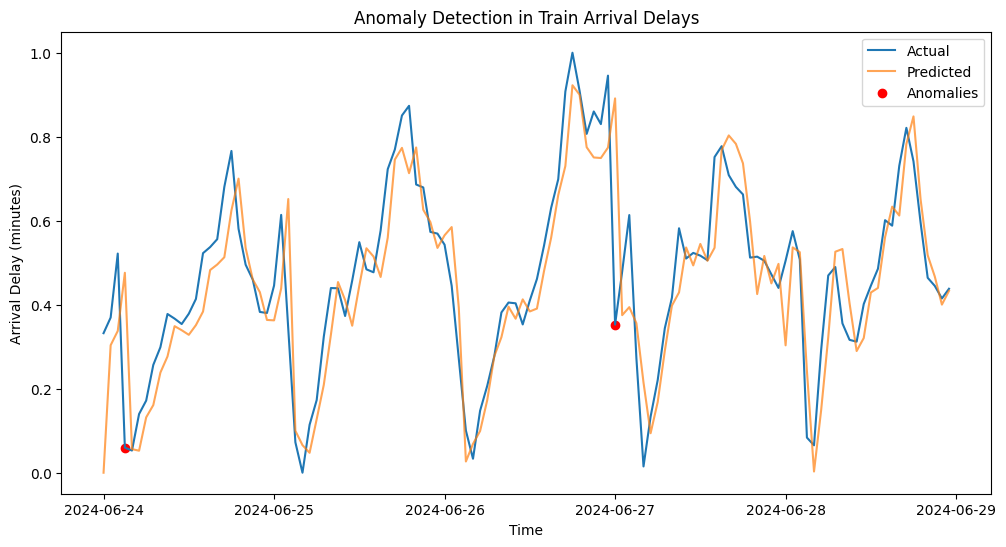

In [106]:
# Detect anomalies
anomalies = residuals[(residuals > upper_threshold) | (residuals < lower_threshold)]

# Plot the anomalies
plt.figure(figsize=(12, 6))
plt.plot(tsa.index, tsa['departure_delay_m'], label='Actual')
plt.plot(tsa.index, pred["departure_delay_m"], label='Predicted', alpha=0.7)
plt.scatter(anomalies.index, tsa.loc[anomalies.index]['departure_delay_m'], color='red', label='Anomalies')
plt.title('Anomaly Detection in Train Arrival Delays')
plt.xlabel('Time')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.show()

Next Steps: fit it to a minute by minute measurement and use it for real time analysis